# Задание **Lite**


Используйте готовый ноутбук с занятия.

1. Соберите обучающую и проверочную выборку (просто запуская последовательно ячейки ноутбука).
2. Обучите полносвязную сеть.
3. Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.
4. Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.
5. Добавьте в сеть слои Dropout.
6. Добавьте в сеть слои BatchNormalization.
7. Поменяйте внутренние активационные функции, варианты: relu, elu, linear.
8. Поменяйте размер batch_size: маленький, средний и большой.

Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках.

Напишите свои выводы.

# Подключение библиотек и дополнительных функций

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import librosa
import numpy as np
import pandas as pd
import time
import os
from google.colab import drive, files
import matplotlib.pyplot as plt

In [ ]:
# Подключение гугл диска
drive.mount('/content/drive')

Mounted at /content/drive


## Дополнительные функции

In [ ]:
# Функция параметризации аудио
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  rmse_mean = np.mean(librosa.feature.rms(y=y))
  spec_cent_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  cpec_bw_mean = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y))

  out = []
  out.append(rmse_mean)
  out.append(spec_cent_mean)
  out.append(cpec_bw_mean)
  out.append(rolloff_mean)
  out.append(zcr_mean)

  for i in chroma_stft:
    out.append(np.mean(i))

  for i in mfcc:
    out.append(np.mean(i))

  return out

In [ ]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []
  # В цикле проходимся по всем значениям из history  
  for i in hist.history.values():
    dct.append(i)                           # Результат выгружаются в словарь.
  result = np.array(dct)                    # Переводим в numpy массив. 
  return result 

In [ ]:
# Создадим таблицу pandas
df = pd.DataFrame(columns=["Кол-во слоев", "Кол-во нейронов", "Активационные функции", "Optimizer", "Batch_size",  "Dropout", "BN", "loss", "accuracy", "val_loss", "val_accuracy"])

# Подготовка данных

In [ ]:
# Распаковка архива
!unzip -q '/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/genres.zip'

# получаем список файлов в распакованной папке
genres = os.listdir('genres')

## Формирование выборок

In [ ]:
# Формирование обучающей выборки
xTrain = []
yTrain=[]

# Циклом проходим по всем жанрам
for i in range(len(genres)):                                   
  curr_time = time.time()                                      
  g = genres[i]                                                
  for filename in os.listdir(f'genres/{g}'):                   
    songname = f'./genres/{g}/{filename}'                      
    y , sr = librosa.load(songname, mono=True, duration=30)    
    out = get_features(y, sr)                                  
    xTrain.append(out)                                         
    yTrain.append(to_categorical(i, len(genres)))        
  
  print("Жанр ", g, " готов за ", round(time.time()- curr_time), "с", sep="")

Жанр country готов за 33с
Жанр reggae готов за 33с
Жанр jazz готов за 33с
Жанр pop готов за 32с
Жанр disco готов за 32с
Жанр blues готов за 32с
Жанр classical готов за 33с
Жанр metal готов за 33с
Жанр hiphop готов за 32с
Жанр rock готов за 33с


In [ ]:
# Обучающую выборку переводим в numpy массивы
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

In [ ]:
# Создаём backup обучающей выборки
xTrain_backup = xTrain.copy()
yTrain_backup = yTrain.copy()

In [ ]:
yTrain_class = np.argmax(yTrain, axis=1)

## Нормирование данных

In [ ]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain_class, test_size=0.1)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(900, 37)
(900,)
(100, 37)
(100,)


In [ ]:
# И сохраняем numpy массивы на гугл диск. Чтобы в дальнейшем не создавать заного выборки. Так как создаются они долго
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTrain', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTest', xTest)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTrain', yTrain)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTest', yTest)

In [ ]:
# Раскомментировать если нужно загрузить готовые выборки из гугл диска
# xTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTrain.npy')
# xTest = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTest.npy')
# yTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTrain.npy')
# yTest = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTest.npy')

# Нейронные сети

Обучение нейронных сетей будет происходить в цикле, добавляя каждый раз данные в таблицу **pandas**, чтобы в конце сравнить результаты и сделать вывод.

Параметр **verbose** установлен в **0**. Чтобы не было длинного вывода. Так как важны только крайние значения, которые будут предоставлены в сравнительной таблице.

Так как процесс довольно долгий, то чтобы отслеживать текущее состояние в выводе будет выводится лишь каждая иттерация цикла. Текущий номер, наличие или отсутствие **Dropout** и **BatchNormalization**, а также текущие значение **активационной функции**, **оптимизатора** и размера **batch_size**.

   А так же будет считаться общее время на обучение. 

In [ ]:
# Зададим нужные переменные
batchNormalization =  ['No', 'Yes']
dropout = ['No', 'Yes']
activ_func= ['elu', 'relu', 'linear', 'softmax']
optimizer= ['Adam', 'RMSprop']
batch_size = [10, 50, 100]
count = 1                   # Счетчик экспериментов

In [ ]:
# 2. Обучите полносвязную сеть.

curr_time = time.time() 

for b_n in batchNormalization:
  for d_o in dropout:
    for b_s in batch_size:
      for opt in optimizer:
        for a_f in activ_func:
          
          print(count)
          print(b_n)
          print(d_o)
          print(b_s)
          print(opt)
          print(a_f)
          print()
          print()

          if d_o == 'No'and b_n == 'No':     # Если не используются Dropout и BatchNormalization

            model = Sequential()
            model.add(Dense(250, activation=a_f, input_shape=(37,)))
            model.add(Dense(125, activation=a_f))
            model.add(Dense(64, activation=a_f))
            model.add(Dense(10, activation='softmax'))

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)   # C помощью функции получаем значения

            # Заносим результат в таблицу
            df.loc[f'{count} - Полносвязная сеть Dense'] = ['4', '250-125-64-10', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1

            # 3. Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.

            model = Sequential()
            model.add(Dense(10, activation=a_f, input_shape=(37,)))

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)  
            df.loc[f'{count} - Простая сеть Dense'] = ['1', '10', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1

            # 4. Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.

            input1 = Input((37,))

            x1 = Dense(1000, activation=a_f)(input1)
            x1 = Dense(500, activation='softmax')(x1)

            x2 = Dense(800, activation=a_f)(input1)
            x2 = Dense(250, activation='softmax')(x2)

            x3 = Dense(500, activation='softmax')(input1)

            x = concatenate([x1, x2, x3])

            x = Dense(250, activation=a_f)(x)
            x = Dense(10, activation='softmax')(x)

            model = Model(input1, x)

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)  
            df.loc[f'{count} - Сложную сеть '] = ['7', '10-100', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1
          
          # 5. Добавьте в сеть слои Dropout

          if d_o == 'Yes' and b_n == 'No':    # Если есть Dropout, но без BatchNormalization
          
            model = Sequential()
            model.add(Dense(250, activation=a_f, input_shape=(37,)))
            model.add(Dense(125, activation=a_f))
            model.add(Dropout(0.3))
            model.add(Dense(64, activation=a_f))
            model.add(Dropout(0.2))
            model.add(Dense(10, activation='softmax'))

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)   
            df.loc[f'{count} - Полносвязная сеть Dense'] = ['4', '250-125-64-10', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1
            
            # Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.

            input1 = Input((37,))

            x1 = Dense(1000, activation=a_f)(input1)
            x1 = Dense(500, activation='softmax')(x1)
            x1 = Dropout(0.3)(x1)

            x2 = Dense(800, activation=a_f)(input1)
            x2 = Dense(250, activation='softmax')(x2)
            x2 = Dropout(0.25)(x2)

            x3 = Dense(500, activation='softmax')(input1)
            x3 = Dropout(0.2)(x3)

            x = concatenate([x1, x2, x3])

            x = Dense(250, activation=a_f)(x)
            x = Dropout(0.2)(x)
            x = Dense(10, activation='softmax')(x)

            model = Model(input1, x)

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)   
            df.loc[f'{count} - Сложная сеть '] = ['7', '10-100', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1

          # 6. Добавьте в сеть слои BatchNormalization.

          if d_o == 'Yes' and b_n == 'Yes':    # Если есть слои Dropout и BatchNormalization

            model = Sequential()
            model.add(Dense(250, activation=a_f, input_shape=(37,)))
            model.add(BatchNormalization())
            model.add(Dense(125, activation=a_f))
            model.add(Dropout(0.3))
            model.add(Dense(64, activation=a_f))
            model.add(Dropout(0.2))
            model.add(Dense(10, activation='softmax'))

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)   
            df.loc[f'{count} - Полносвязная сеть Dense'] = ['4', '250-125-64-10', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1

            # Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.

            input1 = Input((37,))

            x1 = Dense(1000, activation=a_f)(input1)
            x1 = BatchNormalization()(x1)
            x1 = Dense(500, activation='softmax')(x1)
            x1 = BatchNormalization()(x1)
            x1 = Dropout(0.3)(x1)

            x2 = Dense(800, activation=a_f)(input1)
            x2 = BatchNormalization()(x2)
            x2 = Dense(250, activation='softmax')(x2)
            x2 = BatchNormalization()(x2)
            x2 = Dropout(0.25)(x2)

            x3 = Dense(500, activation=a_f)(input1)
            x3 = BatchNormalization()(x3)
            x3 = Dropout(0.2)(x3)

            x = concatenate([x1, x2, x3])

            x = Dense(250, activation=a_f)(x)
            x = BatchNormalization()(x)
            x = Dropout(0.2)(x)
            x = Dense(10, activation='softmax')(x)

            model = Model(input1, x)

            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(xTrain, yTrain, epochs=500, batch_size=b_s, validation_data=(xTest, yTest), verbose=0)

            result = table(history)   
            df.loc[f'{count} - Сложная сеть '] = ['7', '100-1000', a_f, str(opt), b_s, d_o, b_n,  min(result[0]), max(result[1]), min(result[2]), max(result[3])]
            count += 1

end_time = time.time() 

1
No
No
10
Adam
elu


4
No
No
10
Adam
relu


7
No
No
10
Adam
linear


10
No
No
10
Adam
softmax


13
No
No
10
RMSprop
elu


16
No
No
10
RMSprop
relu


19
No
No
10
RMSprop
linear


22
No
No
10
RMSprop
softmax


25
No
No
50
Adam
elu


28
No
No
50
Adam
relu


31
No
No
50
Adam
linear


34
No
No
50
Adam
softmax


37
No
No
50
RMSprop
elu


40
No
No
50
RMSprop
relu


43
No
No
50
RMSprop
linear


46
No
No
50
RMSprop
softmax


49
No
No
100
Adam
elu


52
No
No
100
Adam
relu


55
No
No
100
Adam
linear


58
No
No
100
Adam
softmax


61
No
No
100
RMSprop
elu


64
No
No
100
RMSprop
relu


67
No
No
100
RMSprop
linear


70
No
No
100
RMSprop
softmax


73
No
Yes
10
Adam
elu


75
No
Yes
10
Adam
relu


77
No
Yes
10
Adam
linear


79
No
Yes
10
Adam
softmax


81
No
Yes
10
RMSprop
elu


83
No
Yes
10
RMSprop
relu


85
No
Yes
10
RMSprop
linear


87
No
Yes
10
RMSprop
softmax


89
No
Yes
50
Adam
elu


91
No
Yes
50
Adam
relu


93
No
Yes
50
Adam
linear


95
No
Yes
50
Adam
softmax


97
No
Yes
50
RMSprop
elu


99
No
Ye

In [ ]:
print(f"Общее время обучения всей нейронных сетей составило: {round((end_time - curr_time) / 3600, 2)} часов")

Общее время обучения всей нейронных сетей составило: 5.3 часов


In [ ]:
# Сохраним полученную таблицу
df.to_csv('/content/drive/MyDrive/УИИ/Обработка аудио/Результат/DataFrame_audio.csv', index=True)

In [ ]:
df

,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
1 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,No,No,0.001084,1.000000,1.206378,0.73
2 - Простая сеть Dense,1,10,elu,Adam,10,No,No,1.542806,0.613333,1.915932,0.53
3 - Сложную сеть,7,10-100,elu,Adam,10,No,No,0.001681,0.998889,1.213926,0.70
4 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,10,No,No,0.001582,0.998889,1.218033,0.69
5 - Простая сеть Dense,1,10,relu,Adam,10,No,No,1.684071,0.437778,2.278239,0.41
...,...,...,...,...,...,...,...,...,...,...,...
164 - Сложная сеть,7,100-1000,relu,RMSprop,100,Yes,Yes,0.001536,1.000000,1.077909,0.73
165 - Полносвязная сеть Dense,4,250-125-64-10,linear,RMSprop,100,Yes,Yes,0.816964,0.723333,1.210067,0.64
166 - Сложная сеть,7,100-1000,linear,RMSprop,100,Yes,Yes,0.016361,0.995556,1.209083,0.69
167 - Полносвязная сеть Dense,4,250-125-64-10,softmax,RMSprop,100,Yes,Yes,1.116268,0.587778,1.430980,0.52


In [ ]:
# Раскоментировать код, если нужно.
# Загрузим датафрейм
# df = pd.read_csv('/content/drive/MyDrive/УИИ/Обработка аудио/Результат/DataFrame_audio.csv')

# Так как название первого столбца было пустым, то после загрузки название данного столбца стало Unnamed: 0
# Чтобы это исправить переименуем его
# df.rename(columns = {'Unnamed: 0':'Название сети'}, inplace = True)

# Анализ таблицы

Так как таблица получилась довольно большая, то чтобы понять какие же варианты показали лучшие результаты воспользуемся сортировкой.

## Сортировка по val_accuracy

In [ ]:
# Сортировка по точности на проверочной выборке
df.sort_values('val_accuracy', ascending=False).head(10)

,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
137,138 - Сложная сеть,7,100-1000,elu,Adam,50,Yes,Yes,0.008533,0.998889,1.108897,0.75
80,81 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,10,Yes,No,0.015817,0.995556,1.181963,0.75
120,121 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,Yes,Yes,0.066890,0.980000,1.101982,0.75
72,73 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,Yes,No,0.012064,0.996667,1.202020,0.75
136,137 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,50,Yes,Yes,0.017450,0.994444,1.111744,0.75
138,139 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,50,Yes,Yes,0.005287,0.998889,1.076759,0.74
82,83 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,10,Yes,No,0.003015,1.000000,1.118669,0.74
144,145 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,50,Yes,Yes,0.016125,0.994444,1.141235,0.74
139,140 - Сложная сеть,7,100-1000,relu,Adam,50,Yes,Yes,0.002434,1.000000,1.096095,0.74
88,89 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,50,Yes,No,0.012920,0.997778,1.173076,0.74


## Сортировка по val_loss

In [ ]:
# Сортировка по наименьшей ошибки на проверочной выборке
df.sort_values('val_loss').head(10)

,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
90,91 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,50,Yes,No,0.002133,1.000000,1.036264,0.73
162,163 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,100,Yes,Yes,0.002325,1.000000,1.041018,0.72
63,64 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,100,No,No,0.001542,1.000000,1.045075,0.71
77,78 - Сложная сеть,7,10-100,linear,Adam,10,Yes,No,0.004145,1.000000,1.060107,0.73
146,147 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,50,Yes,Yes,0.003171,1.000000,1.062146,0.73
154,155 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,100,Yes,Yes,0.002925,1.000000,1.062525,0.73
123,124 - Сложная сеть,7,100-1000,relu,Adam,10,Yes,Yes,0.023159,0.992222,1.062587,0.72
138,139 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,50,Yes,Yes,0.005287,0.998889,1.076759,0.74
163,164 - Сложная сеть,7,100-1000,relu,RMSprop,100,Yes,Yes,0.001536,1.000000,1.077909,0.73
147,148 - Сложная сеть,7,100-1000,relu,RMSprop,50,Yes,Yes,0.002640,1.000000,1.081547,0.73


## Различные виды сортировки

### Сортировка - RMSprop, Batch_size = 10	

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 10) & (df.Optimizer == 'RMSprop')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
80,81 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,10,Yes,No,0.015817,0.995556,1.181963,0.75
82,83 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,10,Yes,No,0.003015,1.000000,1.118669,0.74
128,129 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,10,Yes,Yes,0.084183,0.977778,1.113273,0.74
135,136 - Сложная сеть,7,100-1000,softmax,RMSprop,10,Yes,Yes,0.007167,0.998889,1.211876,0.73
131,132 - Сложная сеть,7,100-1000,relu,RMSprop,10,Yes,Yes,0.034282,0.991111,1.182162,0.72


### Сортировка - RMSprop, Batch_size = 50	

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 50) & (df.Optimizer == 'RMSprop')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
144,145 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,50,Yes,Yes,0.016125,0.994444,1.141235,0.74
96,97 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,50,Yes,No,0.010570,0.997778,1.197919,0.74
147,148 - Сложная сеть,7,100-1000,relu,RMSprop,50,Yes,Yes,0.002640,1.000000,1.081547,0.73
146,147 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,50,Yes,Yes,0.003171,1.000000,1.062146,0.73
98,99 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,50,Yes,No,0.001139,1.000000,1.145627,0.71


### Сортировка - RMSprop, Batch_size = 100

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 100) & (df.Optimizer == 'RMSprop')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
112,113 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,100,Yes,No,0.010013,0.997778,1.161114,0.73
161,162 - Сложная сеть,7,100-1000,elu,RMSprop,100,Yes,Yes,0.003472,1.000000,1.165213,0.73
163,164 - Сложная сеть,7,100-1000,relu,RMSprop,100,Yes,Yes,0.001536,1.000000,1.077909,0.73
162,163 - Полносвязная сеть Dense,4,250-125-64-10,relu,RMSprop,100,Yes,Yes,0.002325,1.000000,1.041018,0.72
160,161 - Полносвязная сеть Dense,4,250-125-64-10,elu,RMSprop,100,Yes,Yes,0.014669,0.998889,1.105647,0.72


### Сортировка - Adam, Batch_size = 10	

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 10) & (df.Optimizer == 'Adam')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
120,121 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,Yes,Yes,0.066890,0.980000,1.101982,0.75
72,73 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,Yes,No,0.012064,0.996667,1.202020,0.75
122,123 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,10,Yes,Yes,0.035359,0.990000,1.134158,0.74
0,1 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,10,No,No,0.001084,1.000000,1.206378,0.73
77,78 - Сложная сеть,7,10-100,linear,Adam,10,Yes,No,0.004145,1.000000,1.060107,0.73


### Сортировка - Adam, Batch_size = 50	

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 50) & (df.Optimizer == 'Adam')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
137,138 - Сложная сеть,7,100-1000,elu,Adam,50,Yes,Yes,0.008533,0.998889,1.108897,0.75
136,137 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,50,Yes,Yes,0.017450,0.994444,1.111744,0.75
138,139 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,50,Yes,Yes,0.005287,0.998889,1.076759,0.74
139,140 - Сложная сеть,7,100-1000,relu,Adam,50,Yes,Yes,0.002434,1.000000,1.096095,0.74
88,89 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,50,Yes,No,0.012920,0.997778,1.173076,0.74


### Сортировка - Adam, Batch_size = 100

In [ ]:
df.sort_values('val_accuracy', ascending=False)[(df.Batch_size == 100) & (df.Optimizer == 'Adam')].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Название сети,Кол-во слоев,Кол-во нейронов,Активационные функции,Optimizer,Batch_size,Dropout,BN,loss,accuracy,val_loss,val_accuracy
153,154 - Сложная сеть,7,100-1000,elu,Adam,100,Yes,Yes,0.007043,0.998889,1.130267,0.73
154,155 - Полносвязная сеть Dense,4,250-125-64-10,relu,Adam,100,Yes,Yes,0.002925,1.000000,1.062525,0.73
152,153 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,100,Yes,Yes,0.019439,0.995556,1.124876,0.73
104,105 - Полносвязная сеть Dense,4,250-125-64-10,elu,Adam,100,Yes,No,0.010773,0.998889,1.127938,0.72
155,156 - Сложная сеть,7,100-1000,relu,Adam,100,Yes,Yes,0.002599,1.000000,1.119658,0.72


## Тепловая карта таблицы

Возьмем последние 4 столбца таблицы: **loss**, **accuracy**,	**val_loss** и **val_accuracy**

Так как в таблицу занесены значения:
  - до 72 строки без **Dropout** и **BatchNormalization**
  - c 72 по 120 только с **Dropout**
  - со 120 и до конца с **Dropout** и **BatchNormalization**

То можно визуально видеть, что включение данных слоев в нейронную сеть увеличивают точность и уменьшают ошибку. 

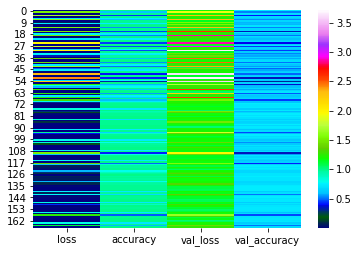

In [ ]:
import seaborn as sns
heatmap_plot = sns.heatmap(df.iloc[:,8:], cmap='gist_ncar') 
plt.show()

# Выводы:

1. Для того чтобы добиться наилучших показателей работы нейронной сети следует перебирать множество архитектур и гиперпараметров.
2. Использование циклов существенно экономит время.
3. Добавление данных в таблицу **pandas** позволяет проанализировать полученный результат. 
4. Общее время обучения всей нейронных сетей составило: **5.3** часа.
5. В работе использовались архитектуры: 
    - Полносвязная сеть **Dense**	

            model = Sequential()
            model.add(Dense(250, activation=a_f, input_shape=(37,)))
            model.add(Dense(125, activation=a_f))
            model.add(Dense(64, activation=a_f))
            model.add(Dense(10, activation='softmax'))

    - Простая сеть **Dense**	

           model = Sequential()
           model.add(Dense(10, activation=a_f, input_shape=(37,)))
    
    -  Сложная сеть

           input1 = Input((37,))

            x1 = Dense(1000, activation=a_f)(input1)
            x1 = Dense(500, activation='softmax')(x1)
            x1 = Dropout(0.3)(x1)

            x2 = Dense(800, activation=a_f)(input1)
            x2 = Dense(250, activation='softmax')(x2)
            x2 = Dropout(0.25)(x2)

            x3 = Dense(500, activation='softmax')(input1)
            x3 = Dropout(0.2)(x3)

            x = concatenate([x1, x2, x3])

            x = Dense(250, activation=a_f)(x)
            x = Dropout(0.2)(x)
            x = Dense(10, activation='softmax')(x)

            model = Model(input1, x)

    
  А так же их вариации с добавление слоев **Dropout** и **BatchNormalization**.

6. Рассмотрев **10** самых лучших значений по точности на обучающей выборке, можно сделать вывод о том что:

    - Оптимайзеры Adam и RMSprop дают примерно одинаковый результат
    - Размеры **batch_size** равными **10** и **50** тоже одинакого хорошо себя показали. А вот размер **batch_size** равным **100** наоборот.
    - Так же из сортированной таблицы видно, что наличие слоя **Dropoup** улучшает показатели.
    - А вот наличие слоя **BatchNormalization** уже не дает ощутимого результата. 
    - Лучше зарекомендовали себя активационные функции **relu** и **elu** в скрытых слоях. 
    - Использование активационных функций **linear** и **softmax** в скрытых слоях дают плохие показатели.  
    - Применяя более **сложную** сеть не всегда будет самый лучший результат. Это видно из таблицы. Обычная полносвязная сеть из **4** скрытых слоев показала такой же результат как и более сложное. 
    - Но использование совсем **простых** сетей, как с **одним** слоем, дает наихудших результат.

7. Для наилучшего результата требуется:
    - Подбирать лучшую архитектуру нейронной сети
    - Гиперпарамеры
    - Дополнять входные данные
    - Увеличивать обучающую выборку. 

8. Данная домашняя работа позволяет получить определенные знания как изменение архитектуры и гиперпараметров влияет на результат.  

Полученные обучающие и тестовые выборки (**xTrain**, **xTest**, **yTrain**, **yTest**) а так же таблица результатов **DataFrame_audio.csv** доступны по ссылке:

https://drive.google.com/drive/folders/1mANWXdcxjab--E4w6BM79wCOX9Heblfl?usp=sharing